In [55]:
import sys
sys.path.append("../")

In [56]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
from functools import partial
from model_code import *
from attention_model import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import inspect
import random

In [57]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [58]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [59]:
print(logdir)

/tmp/tmprj5vt28x/tensorboard_logs


In [60]:
symbol = input("symbol = ").strip().lower()

In [61]:
dataset_folder = f"../dataset/{symbol}_with_three_image_ema_macd"

In [62]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [63]:
dataset_test = load_dataset_of_each_type_and_combine(f"{dataset_folder}/test", candle_type_and_directory_save)
total_data_test = len(dataset_test)

In [64]:
dataset_train = load_dataset_of_each_type_and_combine(f"{dataset_folder}/train", candle_type_and_directory_save)
total_data_train = len(dataset_train)

In [65]:
def image_time_series(image_shape, days_result, units=128):
    image_time_series_model = CNNAttention(units)
    
    return image_time_series_model, "cnn_attention"

In [66]:
UNITS = 256
function_transform_origin = get_open_close_prices_percent_of_last_days_result_for_three_image_dataset
model_function = image_time_series
image_shape = get_image_shape(dataset_train, index_of_image=0)
model, model_name = model_function(image_shape, days_result)

In [67]:
# batch_size = 2**int(input("batch_size = 2^x, x = ").strip())
is_quick_input_param = input("Quick input parameter? (y/n)").strip().lower() == "y"

if is_quick_input_param:
    batch_size = 3
    STEPS_PER_EPOCH = total_data_train // batch_size + 1
    name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
    name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
    max_epochs = 100
    metric_mae_name = "mae"
    metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
    metric_mse_name = "mse"
    metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
    val_loss_metric_mae_to_stop = -1
    val_loss_metric_mse_to_stop = -1
    start_learning_rate = 0.01
    shuffle_buffer = 300
    number_epochs_to_decrease_lr = 10
    number_epochs_to_wait = 10
else:
    batch_size = int(input("batch_size = ").strip())
    STEPS_PER_EPOCH = total_data_train // batch_size + 1
    name_sub_folder_save_metrics = f"{model_name}_{os.path.basename(dataset_folder)}"
    name_folder_save_metrics = f"sizes/{model_name}_{os.path.basename(dataset_folder)}"
    max_epochs = int(input(f"max_epochs = "))
    metric_mae_name = "mae"
    metric_mae_object = keras.metrics.MeanAbsoluteError(name=metric_mae_name)
    metric_mse_name = "mse"
    metric_mse_object = keras.metrics.MeanSquaredError(name=metric_mse_name)
    val_loss_metric_mae_to_stop = float(input("val_loss_metric_mae_to_stop = "))
    val_loss_metric_mse_to_stop = float(input("val_loss_metric_mse_to_stop = "))
    start_learning_rate = float(input("start_learning_rate = ").strip())
    shuffle_buffer = 300
    number_epochs_to_decrease_lr = int(input("number_epochs_to_decrease_lr = "))
    number_epochs_to_wait = int(input("number_epochs_to_wait = "))

In [68]:
print(f"2^{np.log2(batch_size)}")
print(f"{batch_size=}")
print(f"{max_epochs=}")
print(f"{start_learning_rate=}")
print(f"{STEPS_PER_EPOCH=}")
print(f"{val_loss_metric_mae_to_stop=}")
print(f"{val_loss_metric_mse_to_stop=}")
print(f"{number_epochs_to_decrease_lr=}")
print(f"{number_epochs_to_wait=}")

2^1.584962500721156
batch_size=3
max_epochs=3
start_learning_rate=0.01
STEPS_PER_EPOCH=839
val_loss_metric_mae_to_stop=-1.0
val_loss_metric_mse_to_stop=-1.0
number_epochs_to_decrease_lr=10
number_epochs_to_wait=10


In [69]:
model_name

'cnn_attention'

In [70]:
(total_data_train, total_data_test)

(2515, 64)

In [71]:
dataset_train_1 = dataset_train.shuffle(shuffle_buffer)
dataset_test_1 = dataset_test.shuffle(shuffle_buffer)

dataset_train_2 = dataset_train_1.batch(batch_size)
dataset_test_2 = dataset_test_1.batch(batch_size)

transform_function = partial(function_transform_origin, days_result)
dataset_train_3 = dataset_train_2.map(transform_function)
dataset_test_3 = dataset_test_2.map(transform_function)

In [72]:
# for item in dataset_test_2:
#     print(item[0].shape)
#     print(item[1].shape)
#     print(item[2].shape)
#     print(item[3].shape)
#     print(item[4].shape)
#     print(item[5].shape)
#     print(item[6].shape)
    
#     item = None
#     break

In [73]:

# for (
#         list_images_30_days,
#         list_images_7_days,
#         list_images_3_days,
#         percent_change_of_open_close_in,
#     ), percent_change_of_open_close_out in dataset_train_3:
#     print(list_images_30_days.shape)
#     print(list_images_7_days.shape)
#     print(list_images_3_days.shape)
#     print(percent_change_of_open_close_in.shape)
#     print(percent_change_of_open_close_out.shape)
    
#     list_images_30_days = None
#     list_images_7_days = None
#     list_images_3_days = None
#     percent_change_of_open_close_in = None
#     percent_change_of_open_close_out = None
#     break

In [74]:
# for features, labels in dataset_train_3.take(1):
#     print(features[0].shape)
#     print(features[1].shape)
#     print(labels.shape)

In [75]:
for (
        list_images_30_days,
        list_images_7_days,
        list_images_3_days,
        percent_change_of_open_close_in,
    ), percent_change_of_open_close_out in dataset_test_3.take(1):
        print(list_images_30_days.shape)
        print(list_images_7_days.shape)
        print(list_images_3_days.shape)
        print(percent_change_of_open_close_in.shape)
        print(percent_change_of_open_close_out.shape)
        break

(3, 287, 287, 3)
(3, 287, 287, 3)
(3, 287, 287, 3)
(3, 4, 2)
(3, 4, 2)


In [76]:
(len(dataset_train_3), len(dataset_test_3))

(839, 22)

In [77]:
class StopAtLossValue(keras.callbacks.Callback):
    def __init__(self, target_loss, metric_name):
        super(StopAtLossValue, self).__init__()
        self.target_loss = target_loss
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        # Lấy giá trị loss từ logs
        current_loss = logs.get(f"val_{self.metric_name}")
        if current_loss is not None and current_loss <= self.target_loss:
            print(f"\nĐạt target loss = {self.target_loss}, dừng training tại epoch {epoch + 1}")
            self.model.stop_training = True


class SaveModelCallback(keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        folder_tmp = f"{self.save_path}/tmp_model"
        file_name = f"{folder_tmp}/model_tmp_{epoch}.keras"
        self.model.save(file_name)  # Lưu toàn bộ model
        

class TrackingLossCallback(keras.callbacks.Callback):
    def __init__(self, metric_mse_name, metric_mae_name):
        super().__init__()
        self.list_epochs = []
        self.list_val_mse_loss = []
        self.list_train_mse_loss = []
        self.list_val_mae_loss = []
        self.list_train_mae_loss = []
        self.metric_mse_name = metric_mse_name
        self.metric_mae_name = metric_mae_name
        self.val_mse_loss_key = f"val_{self.metric_mse_name}"
        self.train_mse_loss_key = f"{self.metric_mse_name}"
        self.val_mae_loss_key = f"val_{self.metric_mae_name}"
        self.train_mae_loss_key = f"{self.metric_mae_name}"

    def on_epoch_end(self, epoch, logs=None):
        # Tạo tên file với số epoch
        self.list_epochs.append(epoch)
        self.list_val_mse_loss.append(logs.get(self.val_mse_loss_key))
        self.list_train_mse_loss.append(logs.get(self.train_mse_loss_key))
        self.list_val_mae_loss.append(logs.get(self.val_mae_loss_key))
        self.list_train_mae_loss.append(logs.get(self.train_mae_loss_key))
    
    def get_df_result(self):
        df = pd.DataFrame({
            "epoch": self.list_epochs,
            self.val_mse_loss_key: self.list_val_mse_loss,
            self.train_mse_loss_key: self.list_train_mse_loss,
            self.val_mae_loss_key: self.list_val_mae_loss,
            self.train_mae_loss_key: self.list_train_mae_loss,
        })
        df.sort_values(self.val_mse_loss_key, inplace=True)
        return df

In [78]:
def get_optimizer(start_learning_rate, number_epochs_to_decrease_lr):
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
        start_learning_rate,
        decay_steps=STEPS_PER_EPOCH*number_epochs_to_decrease_lr,
        decay_rate=1,
        staircase=False
    )
    
    return keras.optimizers.Adam(lr_schedule)

tracking_loss_callback = TrackingLossCallback(metric_mse_name, metric_mae_name)
def get_callbacks(name, metric_name, number_epochs_to_wait):
    return [
        tfdocs.modeling.EpochDots(),
        StopAtLossValue(val_loss_metric_mae_to_stop, metric_mae_name),
        StopAtLossValue(val_loss_metric_mse_to_stop, metric_mse_name),
        SaveModelCallback(dataset_folder),
        tracking_loss_callback,
        keras.callbacks.EarlyStopping(monitor=f'val_loss', patience=number_epochs_to_wait),
        keras.callbacks.TensorBoard(logdir/name)
    ]
  
  
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(start_learning_rate, number_epochs_to_decrease_lr),
    metrics=[
        metric_mae_object,
        metric_mse_object
    ],
)


In [79]:
# # Ví dụ
# all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
# evaluate_all_models_in_dataset_folder(
#     all_models_folder_path, 
#     dataset_test_2,
#     days_result
# )

In [80]:
# # Ví dụ
# all_models_folder_path = os.path.join(os.path.abspath(dataset_folder), "model_save")
# evaluate_all_models_in_dataset_folder(
#     all_models_folder_path, 
#     dataset_test_2,
#     days_result
# )

In [81]:
model.summary()

Model: "cnn_attention_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_encoder_2 (CNNEncoder)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [82]:
encoder_output, last_state = model.encoder({
    "list_images_30_days": list_images_30_days,
    "list_images_7_days": list_images_7_days,
    "list_images_3_days": list_images_3_days,
})

In [83]:
encoder_output.shape

TensorShape([3, 2, 128])

In [84]:
last_state.shape

TensorShape([3, 128])

In [85]:
decoder_output, last_state = model.decoder(encoder_output, percent_change_of_open_close_in, last_state)

In [86]:
decoder_output.shape

TensorShape([3, 4, 2])

In [87]:
last_state.shape

TensorShape([3, 128])

In [88]:
decoder_output

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[-2.7158315 ,  0.7454988 ],
        [-2.964531  ,  0.8110235 ],
        [-1.8570753 ,  0.33938158],
        [-1.4873322 ,  0.38197994]],

       [[ 0.21059568, -0.26418126],
        [-0.72793615,  0.01992054],
        [-2.2738156 ,  0.4588189 ],
        [-1.225419  ,  0.00330043]],

       [[ 1.09746   , -0.28865194],
        [ 0.70654833, -0.09101695],
        [ 0.36520863,  0.08364975],
        [-0.7433624 ,  0.26725197]]], dtype=float32)>

In [89]:
percent_change_of_open_close_out

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[ 4.8105097 ,  0.22663566],
        [10.297076  ,  4.8105097 ],
        [ 0.        ,  9.431123  ],
        [ 1.9483926 ,  0.        ]],

       [[ 0.        ,  0.5189159 ],
        [ 0.8611495 ,  0.        ],
        [ 4.068614  ,  1.3853297 ],
        [ 0.        ,  3.20082   ]],

       [[-1.132419  , -0.17448169],
        [-0.17448169, -0.86306614],
        [-0.86306614, -1.3463886 ],
        [ 0.8665814 ,  0.        ]]], dtype=float32)>

In [90]:
loss = keras.losses.MeanSquaredError()
loss(percent_change_of_open_close_out, decoder_output)

<tf.Tensor: shape=(), dtype=float32, numpy=17.308678>

In [91]:
is_start_train = input("Start train? (y/n): ").lower()[0] == "y"
folder_tmp = f"{dataset_folder}/tmp_model"
if is_start_train:
    os.makedirs(folder_tmp, exist_ok=False)
    history = model.fit(
        dataset_train_3, 
        validation_data=dataset_test_3,
        epochs=max_epochs, 
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=get_callbacks(name_folder_save_metrics, metric_mse_name, number_epochs_to_wait)
    )

Epoch 1/3
839/839 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 9.5387 - mae: 1.9249 - mse: 9.5387
Epoch: 0, loss:9.8687,  mae:1.8953,  mse:9.8687,  val_loss:5.7117,  val_mae:1.4590,  val_mse:5.7117,  
839/839 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - loss: 9.5390 - mae: 1.9248 - mse: 9.5390 - val_loss: 5.7117 - val_mae: 1.4590 - val_mse: 5.7117
Epoch 2/3


2024-12-15 07:05:28.654849: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_16]]
/usr/local/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 5.7117 - val_mae: 1.4590 - val_mse: 5.7117
Epoch 3/3
839/839 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - loss: 9.2521 - mae: 1.7468 - mse: 9.2521 - val_loss: 5.5825 - val_mae: 1.4572 - val_mse: 5.5825


In [92]:
# reloaded = tf.saved_model.load(f'{dataset_folder}/cnn_attention')

# reloaded.predict_next_3_days_prices(
    
#     tf.cast(list_images_7_days, dtype=tf.float64),
#     tf.cast(list_images_3_days, dtype=tf.float64),
#     tf.cast(percent_change_of_open_close_start, dtype=tf.float64)
    
# )

In [93]:
def get_folder_path_to_save_model(model_name):
    new_model_name = model_name
    path_save = f"{dataset_folder}/model_save/{new_model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        random_index = random.randint(0, 100)
        new_model_name = new_model_name + f"_{random_index}"
        path_save = f"{dataset_folder}/model_save/{new_model_name}"
        print(f"-- Change to {path_save}")
    os.makedirs(path_save, exist_ok=False)
    return path_save, new_model_name 

In [94]:
def save_model(model: keras.Sequential, folder_path, new_model_name):
    path_save = f"{folder_path}/{new_model_name}.keras"
    abspath_save = os.path.abspath(path_save)
    model.save(abspath_save)
    return path_save

In [95]:
def save_model_and_config(model: keras.Sequential, epoch):
    folder_path, new_model_name = get_folder_path_to_save_model(f"{model_name}_epoch_{epoch}")
    model_name_saved = save_model(model, folder_path, new_model_name)
    loss = model.evaluate(dataset_test_3)
    config_and_loss = {
        "config": {
            "batch_size": batch_size,
            "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
            "name_sub_folder_save_metrics": name_sub_folder_save_metrics,
            "name_folder_save_metrics": name_folder_save_metrics,
            "max_epochs": max_epochs,
            "val_loss_metric_mae_to_stop": val_loss_metric_mae_to_stop,
            "val_loss_metric_mse_to_stop": val_loss_metric_mse_to_stop,
            "start_learning_rate": start_learning_rate,
            "shuffle_buffer": shuffle_buffer,
            "number_epochs_to_decrease_lr": number_epochs_to_decrease_lr,
            "number_epochs_to_wait": number_epochs_to_wait,
            "model_function": function_transform_origin.__name__,
            "time_created": str(datetime.now()),
            "epoch": epoch
        },
        "loss": {
            "val_mse_loss": loss[0],
            "val_mae_loss": loss[1],
        }
    }
    with open(f"{folder_path}/config_and_loss.json", "w") as file:
        json.dump(config_and_loss, file, indent=2)
        
    with open("./attention_model.py", "r") as file_code:
        code_str = file_code.read()
    
    with open(f"{folder_path}/model_function_code.py", "w", encoding="utf8") as file:
        file.write(code_str)
    
    return new_model_name

In [96]:
list_name_models = []
list_models = []
df_result = tracking_loss_callback.get_df_result()

In [97]:
df_result

,epoch,val_mse,mse,val_mae,mae
2,2,5.582462,10.129103,1.457167,1.827435
0,0,5.711746,9.868653,1.458955,1.895273
1,1,5.711746,0.000000,1.458955,0.000000


In [98]:
if len(df_result) > 0:
    now = datetime.now()
    result = now.strftime("%Y-%m-%d %H:%M:%S")
    os.makedirs(f"{dataset_folder}/loss_train", exist_ok=True)
    df_result.sort_values("epoch").to_excel(f"{dataset_folder}/loss_train/{result}.xlsx", index=False)

In [99]:
if input("save model? (y/n): ").lower()[0] == "y":
    is_save_model_from_tmp = input("Save model from tmp file? (y/n): ").lower()[0] == "y"
    
    if is_save_model_from_tmp:
        while True and os.path.exists(folder_tmp):
            epoch = input(f"Epoch = (s for stop)")
            if not str.isdigit(epoch):
                break
            else:
                epoch = int(epoch)
            
            model_tmp_name = f"model_tmp_{epoch}.keras"
            print(f"Save {model_tmp_name}")
            model_tmp_path = f"{folder_tmp}/{model_tmp_name}"
            if not os.path.exists(model_tmp_path):
                print(f"model {model_tmp_path} does not exist.")
                continue
            
            try:
                model_tmp = keras.models.load_model(model_tmp_path)
                name_model_tmp_saved = save_model_and_config(model_tmp, epoch)
                list_name_models.append(name_model_tmp_saved)
                list_models.append(model_tmp)
            except Exception as err:
                print(f"Error: {err}")
                continue
    
    is_save_last_model = input("Save last model? (y/n): ").lower()[0] == "y"
    if is_save_last_model:
        name_last_model_saved = save_model_and_config(model, "last")
        list_name_models.append(name_last_model_saved)
        list_models.append(model)

is_delete_tmp_model_folder = input("Delete model tmp folder? (y/n): ").lower()[0] == "y"
if is_delete_tmp_model_folder:
    if os.path.exists(folder_tmp):
        shutil.rmtree(folder_tmp)
    else:
        print(f"{folder_tmp} does not exist.")
    

Save model_tmp_2.keras
-- ../dataset/btc_with_three_image_ema_macd/model_save/cnn_attention_epoch_2 already exists
-- Change to ../dataset/btc_with_three_image_ema_macd/model_save/cnn_attention_epoch_2_0
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3486 - mae: 1.5226 - mse: 6.3486


In [100]:
for model_loaded, model_name_loaded in zip(list_models, list_name_models):
    loss = model_loaded.evaluate(dataset_test_3)
    print(f"{model_name_loaded}: {loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9886 - mae: 1.3772 - mse: 4.9886
cnn_attention_epoch_2_0: [5.582462787628174, 1.4571666717529297, 5.582462787628174]


In [101]:
# size_histories = {}
# size_histories[name_sub_folder_save_metrics] = history 

In [102]:
def draw_line(df_result, list_keys, list_labels, title=None):
    if len(df_result) == 0:
        return
    
    list_epochs = df_result["epoch"]
    
    is_need_scale = len(list_keys) == 1
    
    for key, label in zip(list_keys, list_labels):
        list_values = df_result[key]
        
        marker = None
        if is_need_scale:
            marker = "o"
        plt.plot(list_epochs, list_values, label=label, marker=marker)
        
    if is_need_scale:
        min_loss = df_result[list_keys[0]].min()
        max_loss = df_result[list_keys[0]].max()
        scale = (max_loss - min_loss) / 100
        plt.ylim([min_loss - scale, max_loss + scale])
    
    plt.title(title)
    plt.xlabel('Epoch')  # Nhãn trục X
    plt.ylabel('Giá trị mất mát')  # Nhãn trục Y
    plt.axhline(0, color='black', linewidth=0.5)  # Trục ngang
    plt.axvline(0, color='black', linewidth=0.5)  # Trục dọc
    plt.grid(True, linestyle='--', alpha=0.5)  # Thêm lưới
    plt.legend()  # Hiển thị chú thích
    plt.show()

    
df_result_to_draw = df_result.sort_values("epoch", ascending=False)

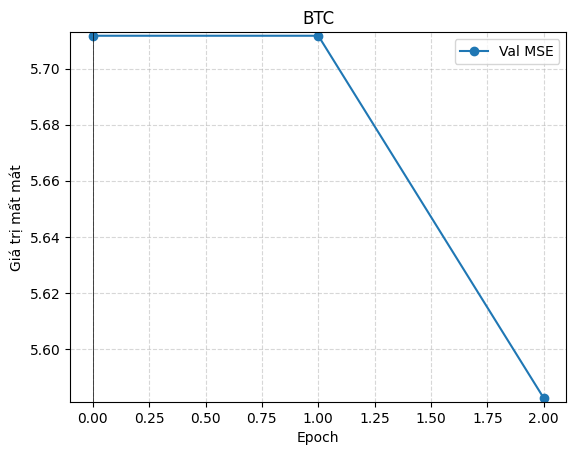

In [103]:
draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        # tracking_loss_callback.train_mse_loss_key,
        tracking_loss_callback.val_mse_loss_key,
    ],
    list_labels=[
        # "Train MSE",
        "Val MSE",
    ],
    title=f"{symbol.upper()}"
)

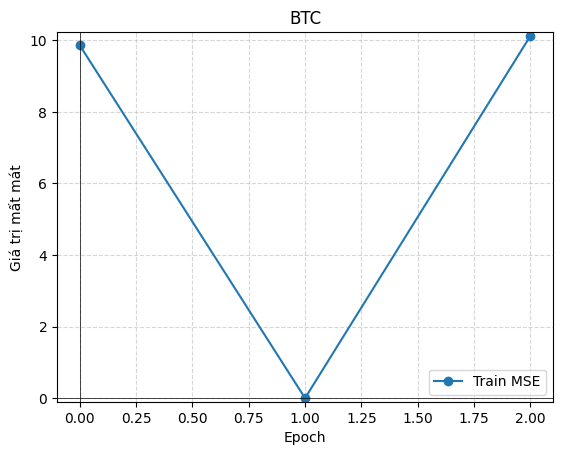

In [104]:
draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        tracking_loss_callback.train_mse_loss_key,
        # tracking_loss_callback.val_mse_loss_key,
    ],
    list_labels=[
        "Train MSE",
        # "Val MSE",
    ],
    title=f"{symbol.upper()}"
)

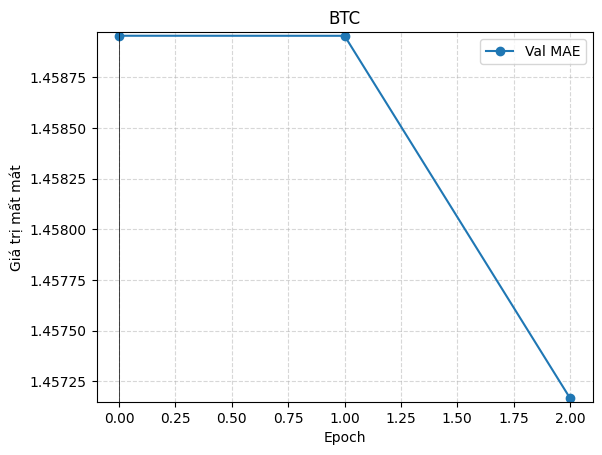

In [105]:
draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        # tracking_loss_callback.train_mae_loss_key,
        tracking_loss_callback.val_mae_loss_key,
    ],
    list_labels=[
        # "Train MAE",
        "Val MAE",
    ],
    title=f"{symbol.upper()}"
)

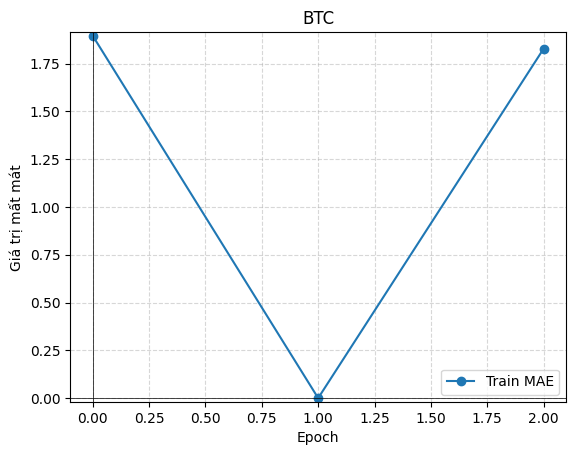

In [106]:
draw_line(
    df_result=df_result_to_draw,
    list_keys=[
        tracking_loss_callback.train_mae_loss_key,
        # tracking_loss_callback.val_mae_loss_key,
    ],
    list_labels=[
        "Train MAE",
        # "Val MAE",
    ],
    title=f"{symbol.upper()}"
)

In [107]:
list_name_models

['cnn_attention_epoch_2_0']

In [108]:
dataset_folder

'../dataset/btc_with_three_image_ema_macd'